In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = [
    'normal',
    'abnormal'
]
#여기에 numpy파일을 여러개 load하면 여러개의 동작데이터를 삽입할 수 있음.

import os

filePath = "dataset"
data = []
idx = 0
for (root, directories, files) in os.walk(filePath):
    for file in files:
        if file.startswith("raw"):# exclude raw dataset
            continue
        print(file)
        file_path = os.path.join(root, file)
        if np.load(file_path).shape[0] == 0:# exclude unavailable array
            continue
        if idx == 0:
            data = np.concatenate([
                np.load(file_path)
            ], axis=0)
        data = np.concatenate([
            np.array(data),
            np.load(file_path)
        ], axis=0)
        idx += 1

data.shape

seq_abnormal_1650122232.npy
seq_abnormal_1650122258.npy
seq_abnormal_1650122293.npy
seq_abnormal_1650122316.npy
seq_abnormal_1650122347.npy
seq_abnormal_1650122365.npy
seq_abnormal_1650122384.npy
seq_abnormal_1650122402.npy
seq_abnormal_1650122419.npy
seq_abnormal_1650122442.npy
seq_abnormal_1650122458.npy
seq_abnormal_1650122480.npy
seq_abnormal_1650122498.npy
seq_abnormal_1650122502.npy
seq_abnormal_1650122509.npy
seq_abnormal_1650122517.npy
seq_abnormal_1650122541.npy
seq_abnormal_1650122556.npy
seq_abnormal_1650122575.npy
seq_abnormal_1650122596.npy
seq_abnormal_1650122622.npy
seq_abnormal_1650122630.npy
seq_abnormal_1650122657.npy
seq_abnormal_1650122674.npy
seq_abnormal_1650122693.npy
seq_abnormal_1650122697.npy
seq_abnormal_1650122715.npy
seq_abnormal_1650122730.npy
seq_abnormal_1650122739.npy
seq_abnormal_1650122752.npy
seq_abnormal_1650122761.npy
seq_abnormal_1650122775.npy
seq_abnormal_1650122792.npy
seq_abnormal_1650122801.npy
seq_abnormal_1650122809.npy
seq_abnormal_1650122

(17198, 30, 162)

In [3]:
x_data = data[:, :, :-1] # 정답레이블 제거
labels = data[:, 0, -1] # 정답레이블 추출

print(x_data.shape)
print(labels.shape)

(17198, 30, 161)
(17198,)


In [4]:
x_data = data[:, :, :-30]
print(x_data.shape)

(17198, 30, 132)


In [5]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions)) # 원핫인코딩 (1,0,0), (0,1,0), (0,0,1)
y_data.shape

(17198, 2)

In [6]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2022) # 학습데이터와 검증데이터 분리

print(x_train.shape, y_train.shape) # 학습데이터 및 정답레이블
print(x_val.shape, y_val.shape) #검증데이터 및 정답레이블

(15478, 30, 132) (15478, 2)
(1720, 30, 132) (1720, 2)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

model = Sequential([
    GRU(units=64, activation='relu', input_shape=x_train.shape[1:3], return_sequences=True),
    Dropout(0.2),
    GRU(units=64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 64)            38016     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 65,122
Trainable params: 65,122
Non-traina

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    batch_size = 256,
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/modelV3.2_GRU_lying.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
60/61 [============================>.] - ETA: 0s - loss: 0.3814 - acc: 0.8414
Epoch 1: val_acc improved from -inf to 0.93081, saving model to models\modelV3.2_GRU_lying.h5
61/61 [==============================] - 5s 65ms/step - loss: 0.3806 - acc: 0.8420 - val_loss: 0.2235 - val_acc: 0.9308 - lr: 0.0010
Epoch 2/200
60/61 [============================>.] - ETA: 0s - loss: 0.2190 - acc: 0.9241
Epoch 2: val_acc improved from 0.93081 to 0.96628, saving model to models\modelV3.2_GRU_lying.h5
61/61 [==============================] - 4s 63ms/step - loss: 0.2191 - acc: 0.9240 - val_loss: 0.1132 - val_acc: 0.9663 - lr: 0.0010
Epoch 3/200
60/61 [============================>.] - ETA: 0s - loss: 0.1367 - acc: 0.9481
Epoch 3: val_acc did not improve from 0.96628
61/61 [==============================] - 4s 63ms/step - loss: 0.1369 - acc: 0.9481 - val_loss: 0.1321 - val_acc: 0.9523 - lr: 0.0010
Epoch 4/200
60/61 [============================>.] - ETA: 0s - loss: 0.0776 - acc: 0.9739
Epoc

KeyboardInterrupt: 

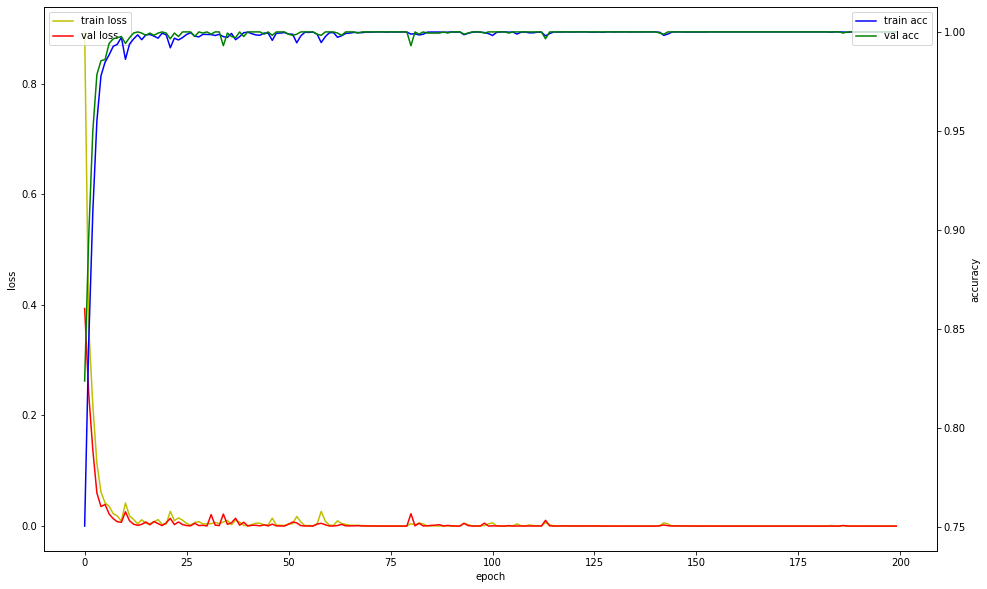

In [18]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()

In [9]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/modelV3.2_GRU_lying.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[ 366,    0],
        [   0, 1354]],

       [[1354,    0],
        [   0,  366]]], dtype=int64)

In [8]:

history.model.save('models/modelV3.3_GRU_lying.h5')


NameError: name 'history' is not defined